# PySPHをSageMakerで使う方法
## PySPHをSageMakerで使ってシミュレーションする手順
1. 前処理
1. シミュレーション
1. 後処理

## 前処理
1. PySPHで使用するParticleArray,Schemeなどを準備
1. S3に送信

### パラメータの作成

In [2]:
from __future__ import print_function

paramet={
'co' : "1400.0",
'ro' : "1.0",
'hdx' : "1.3",
'dx' : "0.025",
'alpha' : "0.1",
'dt' : "5e-6",
'tf' : "0.0076",
}
    
#Test用のパラメータを作成
model_path='model/'
param_path = 'par.json'
import json

with open(param_path, mode='w') as f:
    json.dump(paramet,f)

### アプリケーションの作成

In [3]:
#SageMaker実行時、実行前にカーネルをリスタートすること

from pysph.solver.application import Application

from numpy import ones_like, mgrid, sqrt

from pysph.base.utils import get_particle_array
from pysph.base.utils import get_particle_array_wcsph
from pysph.base.kernels import CubicSpline,Gaussian

from pysph.solver.solver import Solver
from pysph.sph.integrator import EPECIntegrator,EulerIntegrator
from pysph.sph.integrator_step import WCSPHStep,EulerStep

from pysph.sph.equation import Group
from pysph.sph.basic_equations import XSPHCorrection, ContinuityEquation
from pysph.sph.wc.basic import TaitEOS, MomentumEquation
#define Step--------------------------------------------------------------------------------------------------
from pysph.sph.integrator_step import IntegratorStep
class WCSPHStep2(IntegratorStep):
    def initialize(self, d_idx, d_x0, d_y0, d_z0, d_x, d_y, d_z,
                   d_u0, d_v0, d_w0, d_u, d_v, d_w, d_rho0, d_rho):
        d_x0[d_idx] = d_x[d_idx]
        d_y0[d_idx] = d_y[d_idx]
        d_z0[d_idx] = d_z[d_idx]

        d_u0[d_idx] = d_u[d_idx]
        d_v0[d_idx] = d_v[d_idx]
        d_w0[d_idx] = d_w[d_idx]
        
        d_rho0[d_idx] = d_rho[d_idx]

    def stage1(self, d_idx, d_x0, d_y0, d_z0, d_x, d_y, d_z,
                   d_u0, d_v0, d_w0, d_u, d_v, d_w, d_rho0, d_rho, d_au, d_av,
                   d_aw, d_ax, d_ay, d_az, d_arho, dt):
        dtb2 = 0.5*dt
        d_u[d_idx] = d_u0[d_idx] + dtb2*d_au[d_idx]
        d_v[d_idx] = d_v0[d_idx] + dtb2*d_av[d_idx]
        d_w[d_idx] = d_w0[d_idx] + dtb2*d_aw[d_idx]

        d_x[d_idx] = d_x0[d_idx] + dtb2 * d_ax[d_idx]
        d_y[d_idx] = d_y0[d_idx] + dtb2 * d_ay[d_idx]
        d_z[d_idx] = d_z0[d_idx] + dtb2 * d_az[d_idx]

        # Update densities and smoothing lengths from the accelerations
        d_rho[d_idx] = d_rho0[d_idx] + dtb2 * d_arho[d_idx]


    def stage2(self, d_idx, d_x0, d_y0, d_z0, d_x, d_y, d_z,
                   d_u0, d_v0, d_w0, d_u, d_v, d_w, d_rho0, d_rho, d_au, d_av,
                   d_aw, d_ax, d_ay, d_az, d_arho, dt):

        d_u[d_idx] = d_u0[d_idx] + dt*d_au[d_idx]
        d_v[d_idx] = d_v0[d_idx] + dt*d_av[d_idx]
        d_w[d_idx] = d_w0[d_idx] + dt*d_aw[d_idx]

        d_x[d_idx] = d_x0[d_idx] + dt * d_ax[d_idx]
        d_y[d_idx] = d_y0[d_idx] + dt * d_ay[d_idx]
        d_z[d_idx] = d_z0[d_idx] + dt * d_az[d_idx]

        # Update densities and smoothing lengths from the accelerations
        d_rho[d_idx] = d_rho0[d_idx] + dt * d_arho[d_idx]
#define Application--------------------------------------------------------------------------------------------
class Test(Application):
    def initialize(self):
        import json
        with open(param_path, mode='r') as f:
            par = json.load(f)        
        self.co = float(par['co'])
        self.ro = float(par['ro'])
        self.hdx = float(par['hdx'])
        self.dx = float(par['dx'])
        self.alpha = float(par['alpha'])
        self.dt = float(par['dt'])
        self.tf = float(par['tf'])
        
    def create_solver(self):
        kernel = CubicSpline(dim=2)

        integrator = EPECIntegrator(fluid=WCSPHStep2())

        solver = Solver(kernel=kernel, dim=2, integrator=integrator,
                        dt=self.dt, tf=self.tf,pfreq=10)

        return solver

    def create_equations(self):
        equations = [
            Group(
                equations=[
                    TaitEOS(
                        dest='fluid', sources=None, 
                        rho0=self.ro,c0=self.co, gamma=7.0
                    ),
                ],
                real=False
            ),
            Group(equations=[
                ContinuityEquation(dest='fluid',  sources=['fluid']),
                MomentumEquation(
                    dest='fluid', sources=['fluid'],
                    alpha=self.alpha, beta=0.0, c0=self.co
                ),
                XSPHCorrection(
                    dest='fluid', sources=['fluid'], eps=0.0)
            ]),
        ]
        return equations    

    def create_particles(self):
        """Create the circular patch of fluid."""
        name = 'fluid'
        dx=self.dx
        hdx=self.hdx
        ro=self.ro

        x, y = mgrid[-1.05:1.05+1e-4:dx, -1.05:1.05+1e-4:dx]
        x = x.ravel()
        y = y.ravel()

        m = ones_like(x)*dx*dx*ro
        h = ones_like(x)*hdx*dx
        rho = ones_like(x) *ro
        u = -100*x
        v = 100*y

        # remove particles outside the circle
        indices = []
        for i in range(len(x)):
            if sqrt(x[i]*x[i] + y[i]*y[i]) - 1 > 1e-10:
                indices.append(i)

        pa = get_particle_array_wcsph(x=x, y=y, m=m, rho=rho, h=h, u=u, v=v,
                                name=name)
        pa.remove_particles(indices)

        print("Elliptical drop :: %d particles"
              % (pa.get_number_of_particles()))

        pa.set_output_arrays(['x','y','u', 'v', 'rho', 'h', 'p', 'pid', 'tag', 'gid'])
        return [pa]
    
if __name__ == '__main__':
    app = Test(fname=model_path+"Data")
    app.run()    

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/SageMaker/PySPH/model/Data.npz_output/model/Data.npz.log'

上の内容をファイルcalculate.pyに保存



### シミュレーションのdockerイメージをECRに送信

In [6]:
from __future__ import print_function
import subprocess
try:
    print (subprocess.check_output(['./build_and_push.sh', 'psph']).decode('utf-8'))
except subprocess.CalledProcessError as e:
    print(e.output)

Login Succeeded

Step 1/16 : FROM nvidia/opencl:devel-ubuntu16.04
 ---> 58144534b0c2
Step 2/16 : MAINTAINER bamboowonsstring <extra.excramattion1@gmail.com>
 ---> Using cache
 ---> 9e54f51724a0
Step 3/16 : RUN apt-get -y update && apt-get install -y         wget          python3          python3-pip          ca-certificates          python3-dev
 ---> Using cache
 ---> bd9c000e144f
Step 4/16 : RUN apt-get install -y build-essential
 ---> Using cache
 ---> 7378814cf127
Step 5/16 : RUN apt-get install -y python3-numpy
 ---> Using cache
 ---> 24370285be6d
Step 6/16 : RUN apt-get install -y python3-pytest
 ---> Using cache
 ---> 51b3914ca914
Step 7/16 : RUN apt-get install -y cython3
 ---> Using cache
 ---> 6e6a3aeb95bb
Step 8/16 : RUN pip3 install pytools
 ---> Using cache
 ---> 15bd52abc305
Step 9/16 : RUN pip3 install h5py
 ---> Running in 27371a2ed34d
You are using pip version 8.1.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' c

### Dockerイメージのテスト

In [7]:
!cp par.json test_dir/input/config/hyperparameters.json
!./train_local.sh psph

rm: cannot remove ‘test_dir/model/Data_output’: Is a directory
rm: cannot remove ‘test_dir/model/_output’: Is a directory
Elliptical drop :: 5025 particles
Generating output in /opt/ml/model/Data_output
Compiling code at: /root/.pysph/source/py3.5-linux-x86_64/m_4f6a4a3732bc11d302bd13b26f54cfac.pyx
No of particles:
----------------------------------------------------------------------
  fluid: 5025
----------------------------------------------------------------------
Setup took: 5.35927 secs
100%
Run took: 22.87523 secs


### S3に送信

In [10]:
from sagemaker import get_execution_role
import sagemaker as sage
import os
import boto3
resource = boto3.resource('s3') 
my_bucket = resource.Bucket('sagemaker-bucket03')#使用するS3バケット

# my_bucket.upload_file('scheme.pickle',Key='sph/pplication_structure/scheme.pickle')

## シミュレーション

In [11]:
role = get_execution_role()
sess = sage.Session()

# ECSに保存するDocker image名 
# タグはデフォルトで'latest'になる
imagename = 'psph'

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account, region, imagename)

# トレーニングジョブ
# 出力先、使用するインスタンスを指定
sph = sage.estimator.Estimator(image,
                       role, 1, 'ml.c5.4xlarge',
                       output_path="s3://sagemaker-bucket03/sph/output",
                       sagemaker_session=sess)


In [13]:
from numpy import arange

job_names=[]

for dx in arange(0.02,0.1,0.08):
    paramet['dx']=dx
    jobname="psph6-dx--{}".format(dx).replace('.','-')
    print(jobname)
    job_names.append(jobname)
    #シミュレーションに使用するパラメータ
    sph.hyperparam_dict = paramet
    # superradiance.fit("s3://sagemaker-bucket03/sph/application_structure")
    sph.fit(None,job_name=jobname)

INFO:sagemaker:Creating training-job with name: psph6-dx--0-02


psph6-dx--0-02
2019-04-01 08:24:17 Starting - Starting the training job...
2019-04-01 08:24:18 Starting - Launching requested ML instances...
2019-04-01 08:25:15 Starting - Preparing the instances for training...
2019-04-01 08:25:44 Downloading - Downloading input data
2019-04-01 08:25:44 Training - Downloading the training image...
2019-04-01 08:26:04 Training - Training image download completed. Training in progress.
Elliptical drop :: 7860 particles
Generating output in /opt/ml/model/Data_output
Compiling code at: /root/.pysph/source/py3.5-linux-x86_64/m_4f6a4a3732bc11d302bd13b26f54cfac.pyx
No of particles:
----------------------------------------------------------------------
  fluid: 7860
----------------------------------------------------------------------
Setup took: 4.15605 secs
#0150%#0150%#0150%#0150%#0150%#0150%#0150%#0150%#0150%#0150%#0151%#0151%#0151%#0151%#0151%#0151%#0151%#0151%#0151%#0151%#0152%#0152%#0152%#0152%#0152%#0152%#0152%#0152%#0152%#0152%#0153%#0153%#0153%#01

## 後処理

In [14]:
job_names

['psph6-dx--0-02']

In [18]:
import os
import boto3
resource = boto3.resource('s3') 
my_bucket = resource.Bucket('sagemaker-bucket03')#使用するS3バケット

import tarfile

# 結果取得
#job_name= sph.latest_training_job.name
job_name = job_names[0]
#job_name='psph5-dx--0-02'
results = my_bucket.Object('sph/output/{}/output/model.tar.gz'.format(job_name))
tempfile = '/home/ec2-user/SageMaker/model.tar.gz'   
results.download_file(tempfile)   

#  展開
tar = tarfile.open(tempfile, "r:gz")
tar.extractall(path = './Data')

(-2.0, 2.0)

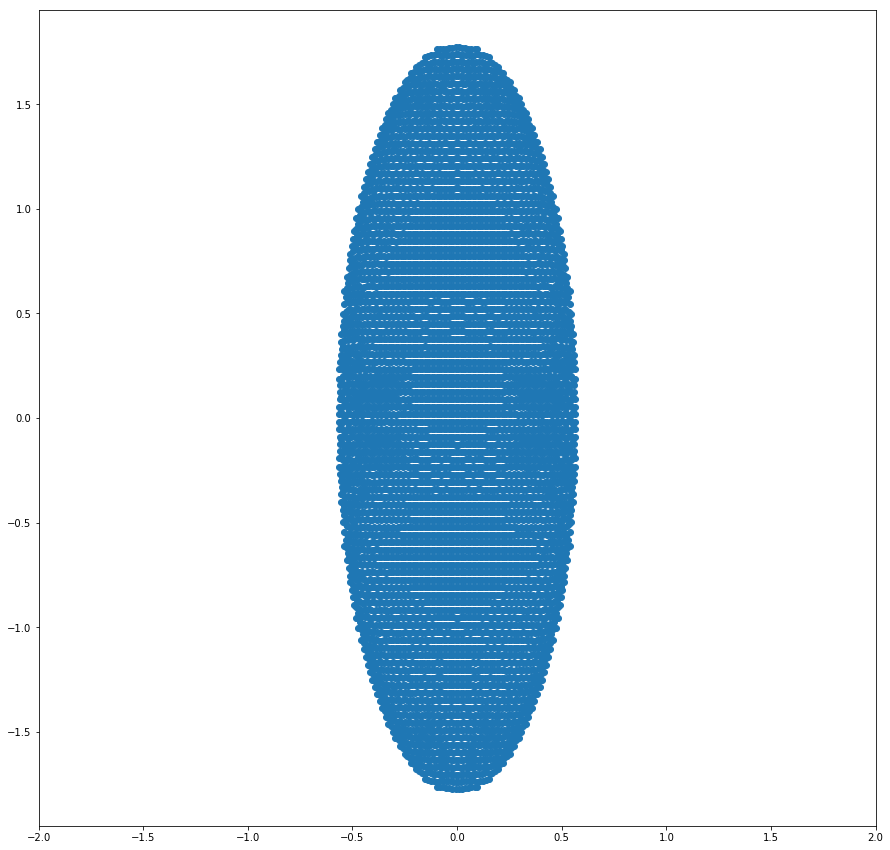

In [34]:
%matplotlib inline

from pysph.solver.utils import load
data = load('Data_output/Data_1300.hdf5')
#data=load("./model/Data_output/model/_0.hdf5")
#data=load("./test_dir/model/Data_150.hdf5")
particle_arrays = data['arrays']
solver_data = data['solver_data']
fluid = particle_arrays['fluid']
x = fluid.x
y = fluid.y

import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(x,y)
plt.xlim(-2.0,2.0)
plt.ylim(-2.0,2.0)

In [186]:
x

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])